In [25]:
import tensorflow 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

# import the model architecture
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

#import optimizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

In [26]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0


In [27]:
# creating the base of the Model - DenseNet121
base_model=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

# adding activation layers to the model
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# output layer for two classes
preds=Dense(2,activation='softmax')(x) #FC-layer

In [28]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [29]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
    

In [30]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [31]:
IMG_SIZE = 128

def takeData(DATADIR, CLASSES):
    images = []
    data = []
    for category in CLASSES:
        path_cases = os.path.join(DATADIR, category)
        num_of_cases = len(os.listdir(path_cases))
        for i in range(num_of_cases):
            path_case = os.path.join(path_cases, "{} ({})".format(CLASSES[category], i+1))
            for img in os.listdir(path_case):
                data = np.load(path_case+'/'+img)
                center = len(data)//2
                new_img = data[center]
                new_img_arr = np.array(new_img)
                new_img_arr = resize(new_img_arr, output_shape = (IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
                images.append([new_img_arr, category])
                break
    return images

In [32]:
CLASSES = {"done_non-COVID-19" : 0, "done_COVID-19" : 1}
DATADIR = "data/"

# take the dataset of masked images of COVID and non_COVID cases
data_array = takeData(DATADIR, CLASSES)
# check the number of samples
print(len(data_array)) 

828


In [33]:
random.seed(0)
random.shuffle(data_array)

image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])

image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))

In [34]:
(xtrain, xtest, ytrain, ytest) = train_test_split(image_data, classes, test_size=0.2, random_state=42)
print(xtrain.shape, xtest.shape)

(662, 128, 128, 3) (166, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
                    steps_per_epoch=xtrain.shape[0] //128,
                    epochs=20,
                    verbose=2,
                    callbacks=[anne, checkpoint],
                    validation_data=(xtrain, ytrain))

Epoch 1/20
5/5 - 10s - loss: 0.1060 - accuracy: 0.9569 - val_loss: 0.0260 - val_accuracy: 0.9970

Epoch 00001: val_loss improved from inf to 0.02603, saving model to model.h5
Epoch 2/20
5/5 - 9s - loss: 0.1068 - accuracy: 0.9516 - val_loss: 0.0276 - val_accuracy: 0.9955

Epoch 00002: val_loss did not improve from 0.02603
Epoch 3/20
5/5 - 9s - loss: 0.1036 - accuracy: 0.9607 - val_loss: 0.0262 - val_accuracy: 0.9955

Epoch 00003: val_loss did not improve from 0.02603
Epoch 4/20
5/5 - 9s - loss: 0.1151 - accuracy: 0.9438 - val_loss: 0.0267 - val_accuracy: 0.9970

Epoch 00004: val_loss did not improve from 0.02603
Epoch 5/20
5/5 - 10s - loss: 0.0977 - accuracy: 0.9625 - val_loss: 0.0271 - val_accuracy: 0.9955

Epoch 00005: val_loss did not improve from 0.02603
Epoch 6/20
5/5 - 9s - loss: 0.0958 - accuracy: 0.9607 - val_loss: 0.0289 - val_accuracy: 0.9940

Epoch 00006: val_loss did not improve from 0.02603
Epoch 7/20
5/5 - 9s - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.0280 - val_accur

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')
print(np.argmax(ypred[5]))

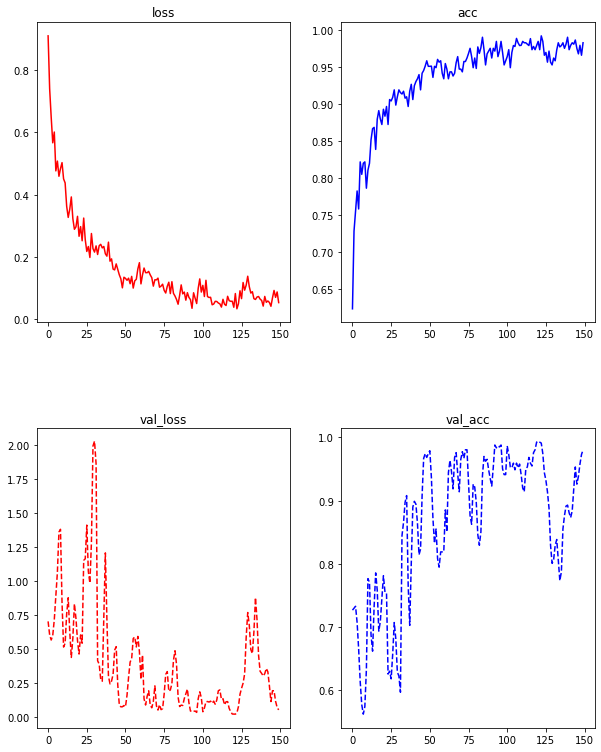

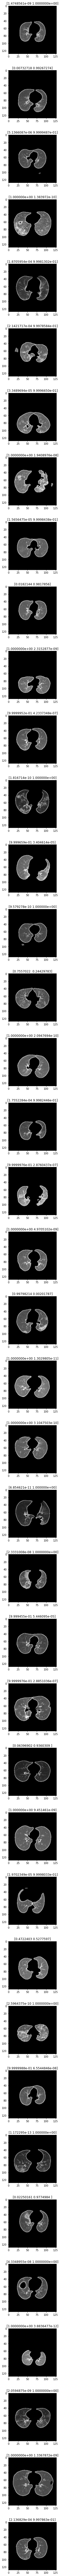

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')

ax[1, 1].plot(history.history['val_accuracy'], 'b--')

preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze())
    ax1[i].title.set_text(str(preds[i]))